In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
def recall(y_target, y_pred):
    
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

In [4]:
def precision(y_target, y_pred):
    
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

In [5]:
def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

# Load Dataset

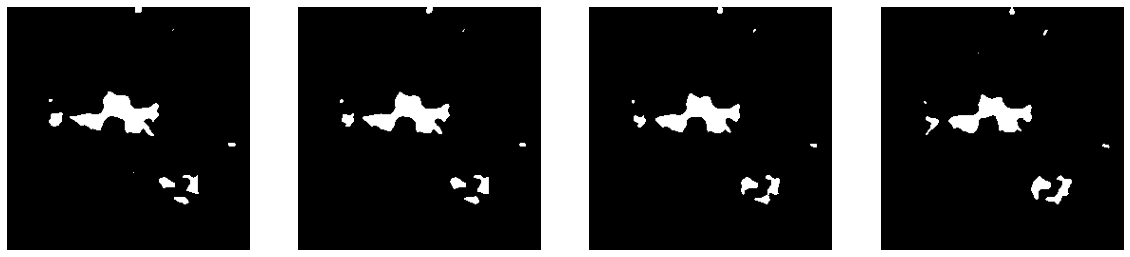

In [6]:
x_train = np.load('x_train_Ti_NCM.npy')
y_train = np.load('y_train_Ti_NCM.npy')
x_val = np.load('x_val_Ti_NCM.npy')
y_val = np.load('y_val_Ti_NCM.npy')

fig, ax = plt.subplots(1, 4, figsize=(20, 20))

for i in range(0, 4):
    ax[i].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i].axis('off')
    

# Build Model

In [9]:
pix_size = 256
inputs = Input(shape=(pix_size, pix_size, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

#model.load_weights('Pore_segnet_weight.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','mse', precision, recall, f1score])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0   

# Train

In [10]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])

Epoch 1/100
4/4 [==============================] - 1s 323ms/step - loss: 0.5913 - accuracy: 0.6570 - mse: 0.2099 - precision: 0.0112 - recall: 0.2499 - f1score: 0.0214 - val_loss: 0.2923 - val_accuracy: 0.9125 - val_mse: 0.0729 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 155ms/step - loss: 0.1984 - accuracy: 0.9452 - mse: 0.0462 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 0.3122 - val_accuracy: 0.9125 - val_mse: 0.0739 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 1s 155ms/step - loss: 0.1997 - accuracy: 0.9452 - mse: 0.0462 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00 - val_loss: 0.2693 - val_accuracy: 0.9125 - val_mse: 0.0709 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00 - lr: 0.0010
Epoch 4/100
4/4 

Epoch 27/100
4/4 [==============================] - 1s 155ms/step - loss: 0.0457 - accuracy: 0.9785 - mse: 0.0127 - precision: 0.8374 - recall: 0.8145 - f1score: 0.8253 - val_loss: 0.1007 - val_accuracy: 0.9498 - val_mse: 0.0300 - val_precision: 0.9597 - val_recall: 0.4953 - val_f1score: 0.6520 - lr: 0.0010
Epoch 28/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0475 - accuracy: 0.9773 - mse: 0.0132 - precision: 0.8488 - recall: 0.7652 - f1score: 0.7993 - val_loss: 0.0737 - val_accuracy: 0.9607 - val_mse: 0.0221 - val_precision: 0.9036 - val_recall: 0.6717 - val_f1score: 0.7699 - lr: 0.0010
Epoch 29/100
4/4 [==============================] - 1s 165ms/step - loss: 0.0462 - accuracy: 0.9776 - mse: 0.0129 - precision: 0.8820 - recall: 0.7488 - f1score: 0.8079 - val_loss: 0.0669 - val_accuracy: 0.9653 - val_mse: 0.0200 - val_precision: 0.8023 - val_recall: 0.8241 - val_f1score: 0.8127 - lr: 0.0010
Epoch 30/100
4/4 [==============================] - 1s 158ms/step - loss:

Epoch 53/100
4/4 [==============================] - 1s 155ms/step - loss: 0.0393 - accuracy: 0.9803 - mse: 0.0110 - precision: 0.8826 - recall: 0.7940 - f1score: 0.8360 - val_loss: 0.0759 - val_accuracy: 0.9598 - val_mse: 0.0226 - val_precision: 0.9236 - val_recall: 0.6438 - val_f1score: 0.7579 - lr: 4.0000e-05
Epoch 54/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0391 - accuracy: 0.9805 - mse: 0.0110 - precision: 0.8757 - recall: 0.8115 - f1score: 0.8423 - val_loss: 0.0732 - val_accuracy: 0.9608 - val_mse: 0.0218 - val_precision: 0.9167 - val_recall: 0.6616 - val_f1score: 0.7677 - lr: 4.0000e-05
Epoch 55/100
4/4 [==============================] - 1s 151ms/step - loss: 0.0391 - accuracy: 0.9805 - mse: 0.0110 - precision: 0.8621 - recall: 0.8246 - f1score: 0.8429 - val_loss: 0.0728 - val_accuracy: 0.9609 - val_mse: 0.0218 - val_precision: 0.9162 - val_recall: 0.6633 - val_f1score: 0.7687 - lr: 4.0000e-05
Epoch 56/100
4/4 [==============================] - 1s 152ms/

4/4 [==============================] - 1s 151ms/step - loss: 0.0387 - accuracy: 0.9805 - mse: 0.0109 - precision: 0.8891 - recall: 0.8115 - f1score: 0.8484 - val_loss: 0.0751 - val_accuracy: 0.9599 - val_mse: 0.0224 - val_precision: 0.9250 - val_recall: 0.6443 - val_f1score: 0.7587 - lr: 1.0000e-05
Epoch 79/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0387 - accuracy: 0.9806 - mse: 0.0109 - precision: 0.8771 - recall: 0.7921 - f1score: 0.8319 - val_loss: 0.0744 - val_accuracy: 0.9603 - val_mse: 0.0222 - val_precision: 0.9231 - val_recall: 0.6497 - val_f1score: 0.7618 - lr: 1.0000e-05
Epoch 80/100
4/4 [==============================] - 1s 152ms/step - loss: 0.0387 - accuracy: 0.9806 - mse: 0.0109 - precision: 0.8689 - recall: 0.8154 - f1score: 0.8412 - val_loss: 0.0737 - val_accuracy: 0.9605 - val_mse: 0.0220 - val_precision: 0.9210 - val_recall: 0.6547 - val_f1score: 0.7645 - lr: 1.0000e-05
Epoch 81/100
4/4 [==============================] - 1s 154ms/step - loss: 

# Evaluation

In [11]:
_mse, _loss, _acc, _precision, _recall, _f1score = model.evaluate(x_val, y_val, batch_size=32, verbose=1)
print('mse: {:.3f}, loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_mse, _loss, _acc, _precision, _recall, _f1score))

4/4 [==============================] - 0s 40ms/step - loss: 0.0748 - accuracy: 0.9601 - mse: 0.0223 - precision: 0.9240 - recall: 0.6468 - f1score: 0.7601
mse: 0.075, loss: 0.960, accuracy: 0.022, precision: 0.924, recall: 0.647, f1score: 0.760


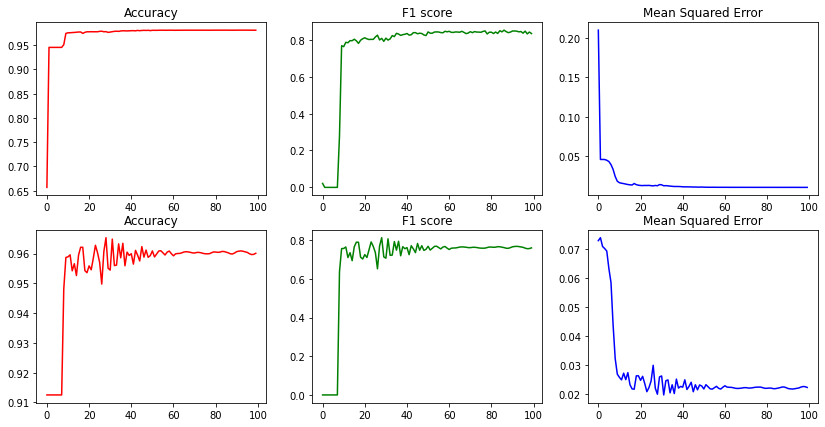

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))

ax[0, 0].set_title('Accuracy')
ax[0, 0].plot(history.history['accuracy'], 'r')
ax[0, 1].set_title('F1 score')
ax[0, 1].plot(history.history['f1score'], 'g')
ax[0, 2].set_title('Mean Squared Error')
ax[0, 2].plot(history.history['mse'], 'b')

ax[1, 0].set_title('Accuracy')
ax[1, 0].plot(history.history['val_accuracy'], 'r')
ax[1, 1].set_title('F1 score')
ax[1, 1].plot(history.history['val_f1score'], 'g')
ax[1, 2].set_title('Mean Squared Error')
ax[1, 2].plot(history.history['val_mse'], 'b')

IndexError: index 5 is out of bounds for axis 0 with size 5

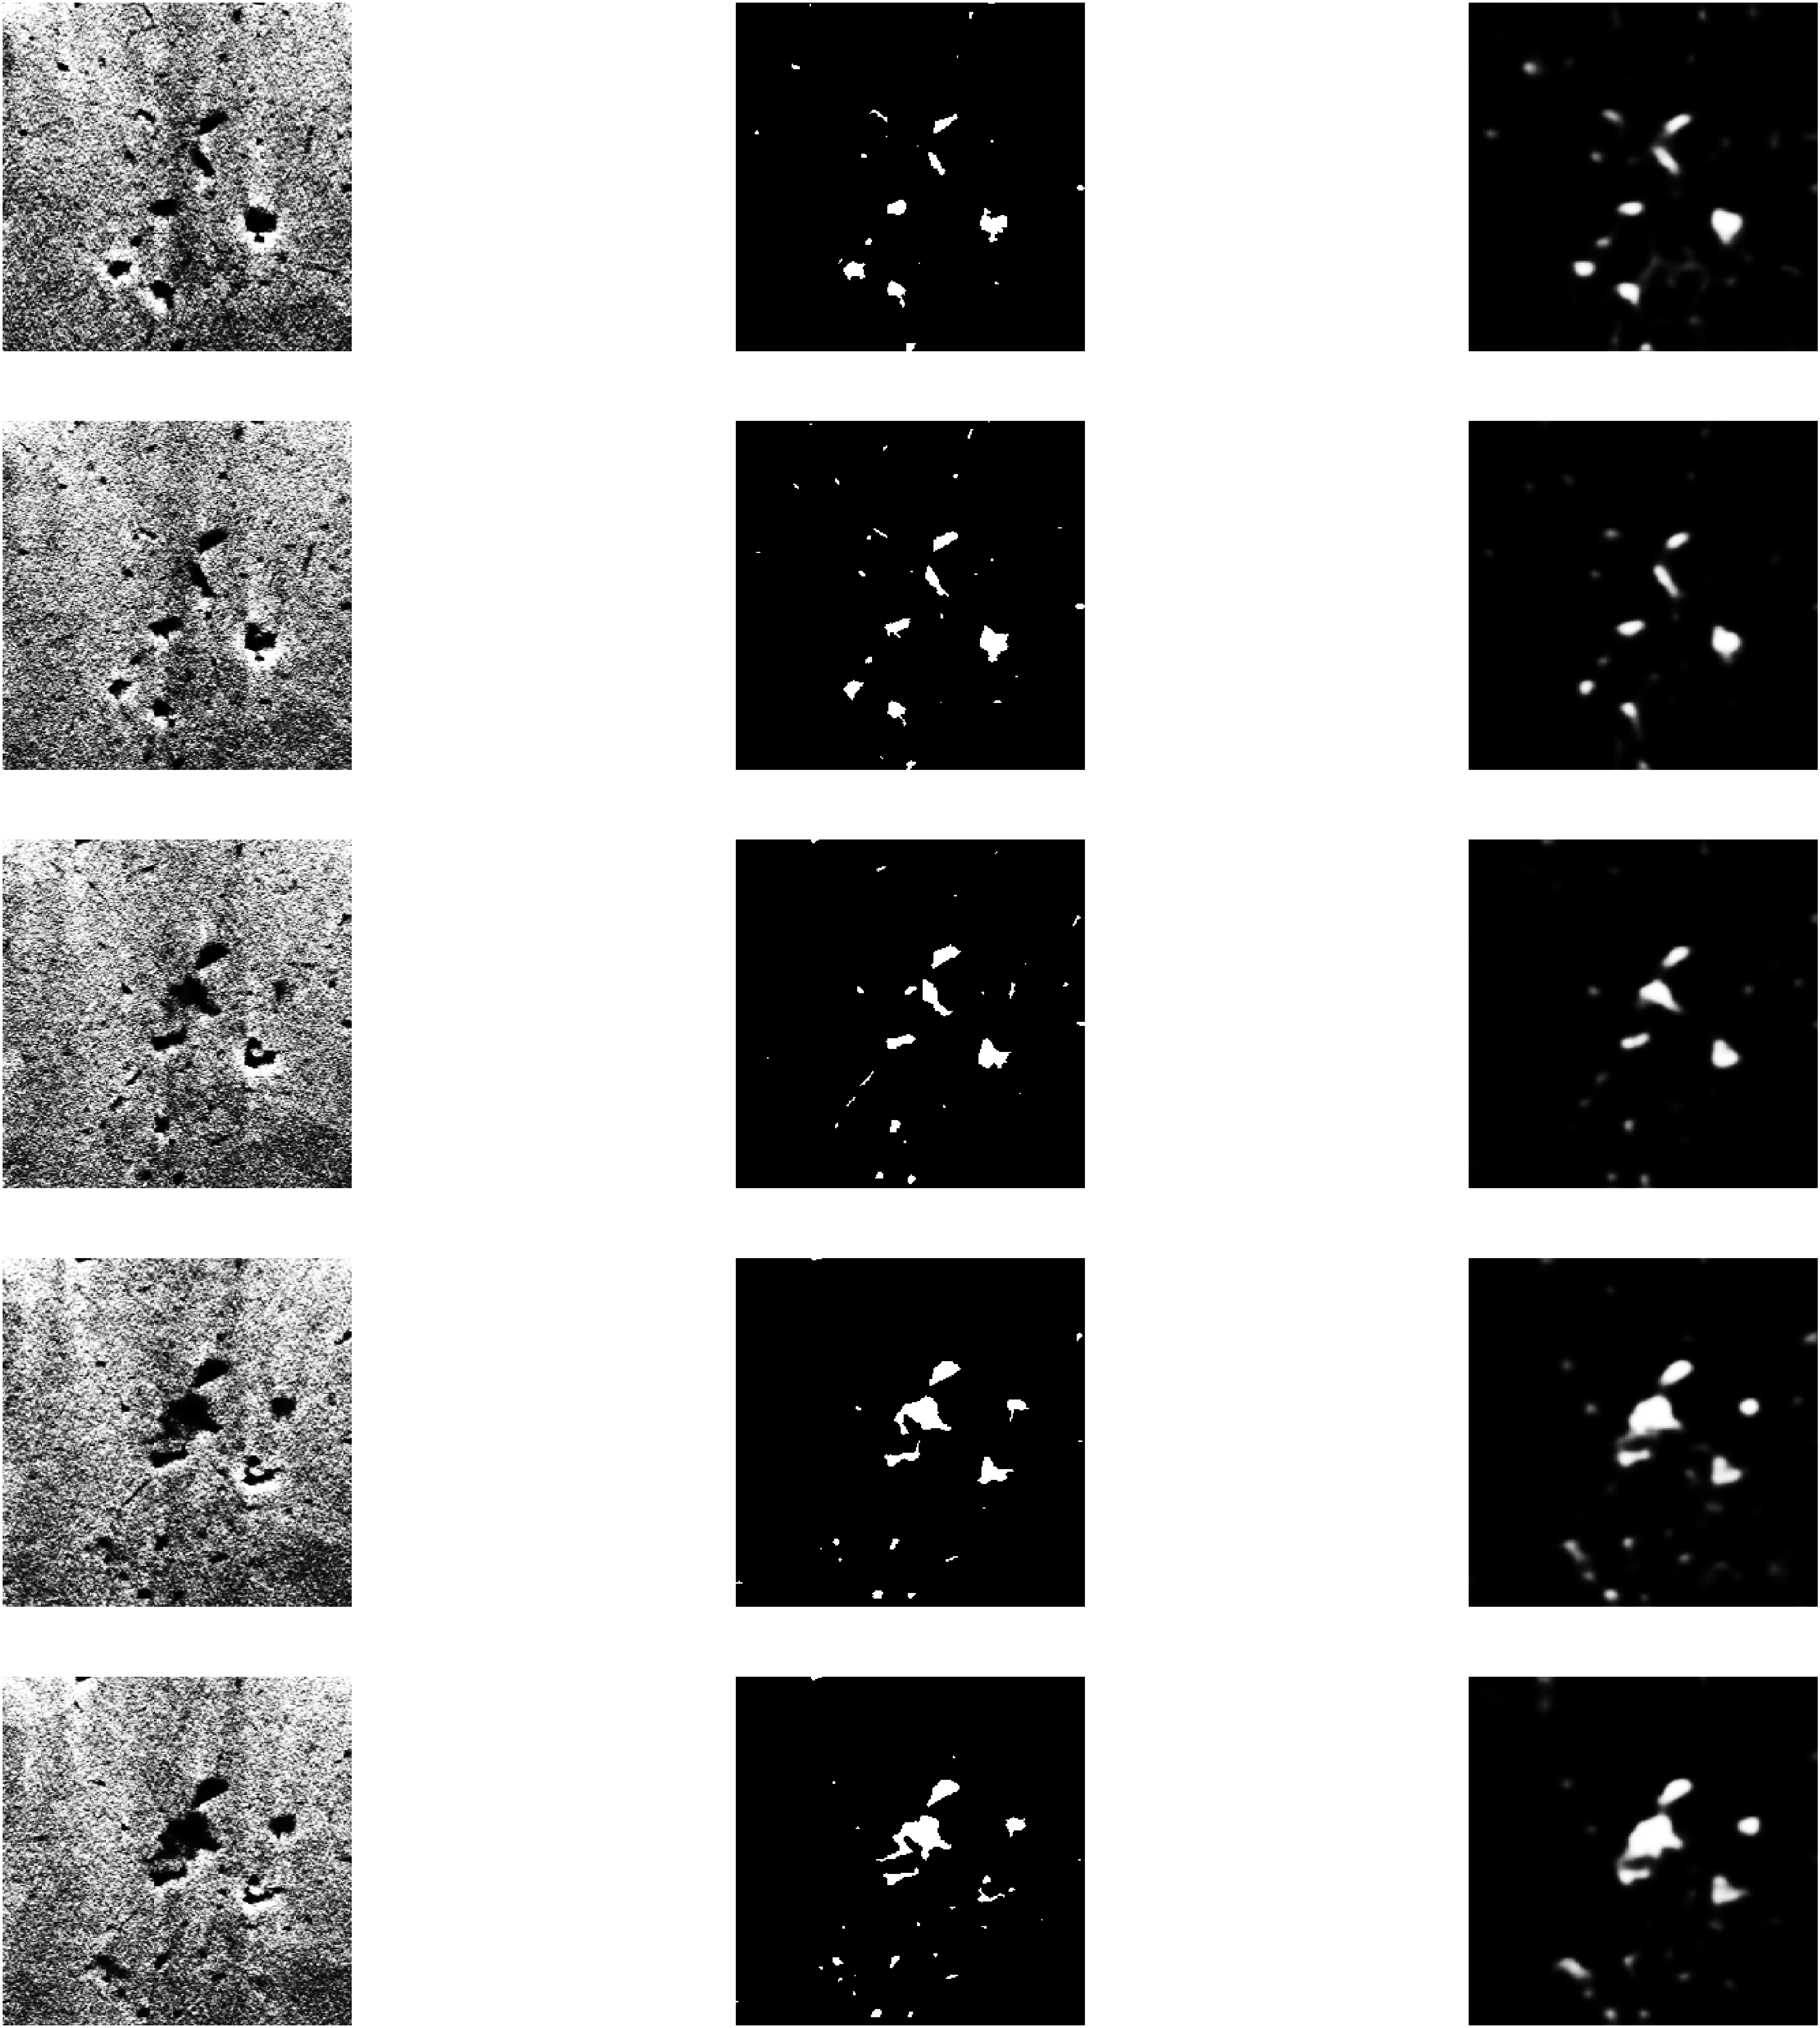

In [38]:
preds = model.predict(x_train)
fig, ax = plt.subplots(5, 3, figsize=(100, 100))


for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_train[i].squeeze(), cmap='gray')
    ax[i, 0].axis('off')
    ax[i, 1].imshow(y_train[i].squeeze(), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')
    ax[i, 2].axis('off')
    tf.keras.preprocessing.image.save_img(f'Pore_segnet_{i+1}.tiff', pred)
   

## save history

In [36]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 


# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save model and weights

In [35]:
#weight save
model.save_weights('Pore_segnet_weight.h5')
model.save_weights('Pore_segnet_weight.hdf5')

# Model save
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

# Model & weight save    
model.save('modelweight.h5')
model.save('modelweight.h5')